In [ ]:
!pip install torch transformers pandas tqdm scikit-learn numpy

In [ ]:
!pip install matplotlib seaborn

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

# Download once and save locally
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Save them
tokenizer.save_pretrained('./bert-base-uncased')
model.save_pretrained('./bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:

# Provide the path to your dataset
file_path = '/content/drive/MyDrive/IMDB Dataset 2.csv'


# Load the dataset
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
# Custom Dataset class for IMDB reviews
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
def plot_training_metrics(training_stats):
    """
    Plot training and validation metrics over epochs
    """
    # Convert training stats to DataFrame for easier plotting
    df_stats = pd.DataFrame(training_stats)

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training and validation loss
    ax1.plot(df_stats['epoch'], df_stats['train_loss'], 'b-o', label='Training Loss')
    ax1.plot(df_stats['epoch'], df_stats['val_loss'], 'r-o', label='Validation Loss')
    ax1.set_title('Training and Validation Loss Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Plot accuracy and F1 score (fixed format string)
    ax2.plot(df_stats['epoch'], df_stats['accuracy'], 'g-o', label='Accuracy')
    ax2.plot(df_stats['epoch'], df_stats['f1'], 'm-o', label='F1 Score')  # Changed from 'p-o' to 'm-o'
    ax2.set_title('Accuracy and F1 Score Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    # Additional plot for Precision and Recall
    plt.figure(figsize=(8, 5))
    plt.plot(df_stats['epoch'], df_stats['precision'], 'b-o', label='Precision')
    plt.plot(df_stats['epoch'], df_stats['recall'], 'r-o', label='Recall')
    plt.title('Precision and Recall Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def train_model(model, train_loader, val_loader, device, epochs=3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5) # lr = learning rate
    best_accuracy = 0
    training_stats = []

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')

        # Training
        model.train()
        train_loss = 0
        train_steps = 0

        for batch in tqdm(train_loader, desc='Training'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            train_loss += loss.item()
            train_steps += 1

            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / train_steps

        # Validation
        model.eval()
        val_loss = 0
        val_steps = 0
        val_preds = []
        val_true = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validation'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                val_loss += loss.item()
                val_steps += 1

                preds = torch.argmax(outputs.logits, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_true.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / val_steps
        accuracy = accuracy_score(val_true, val_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='binary')

        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')

        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), 'best_model.pt')

    return training_stats


In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



Epoch 1/3


Validation: 100%|██████████| 625/625 [01:22<00:00,  7.58it/s]


Training Loss: 0.2406
Validation Loss: 0.1905
Accuracy: 0.9233
Precision: 0.9319
Recall: 0.9147
F1 Score: 0.9232

Epoch 2/3


Validation: 100%|██████████| 625/625 [01:22<00:00,  7.57it/s]


Training Loss: 0.1327
Validation Loss: 0.1981
Accuracy: 0.9233
Precision: 0.9286
Recall: 0.9184
F1 Score: 0.9235

Epoch 3/3


Validation: 100%|██████████| 625/625 [01:22<00:00,  7.60it/s]


Training Loss: 0.0697
Validation Loss: 0.2683
Accuracy: 0.9205
Precision: 0.9036
Recall: 0.9428
F1 Score: 0.9228


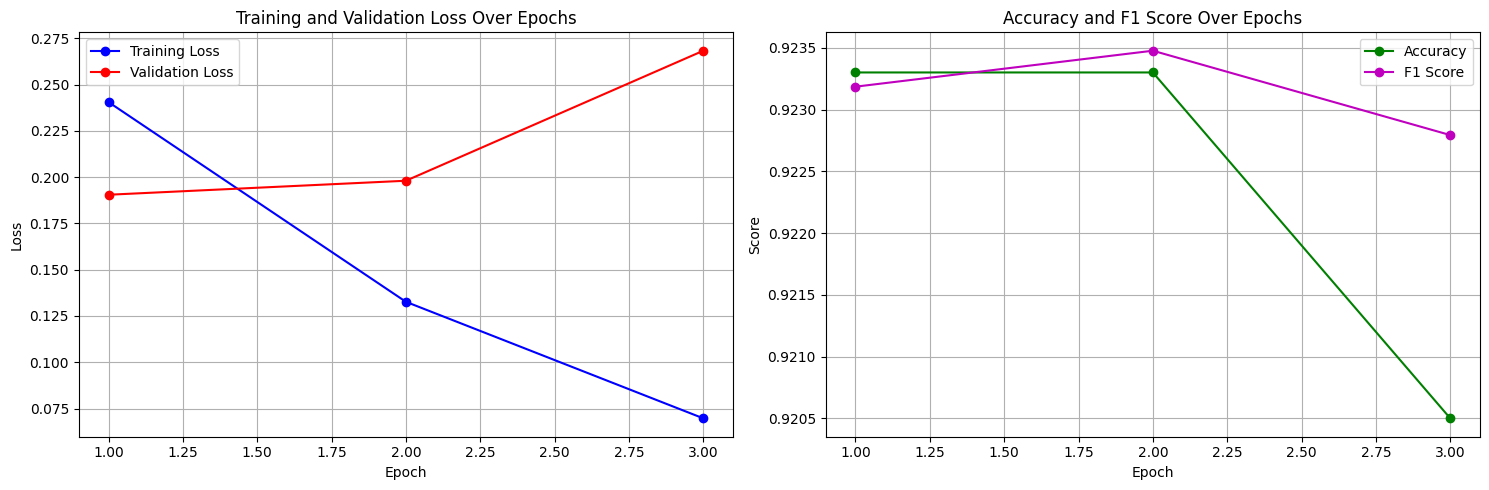

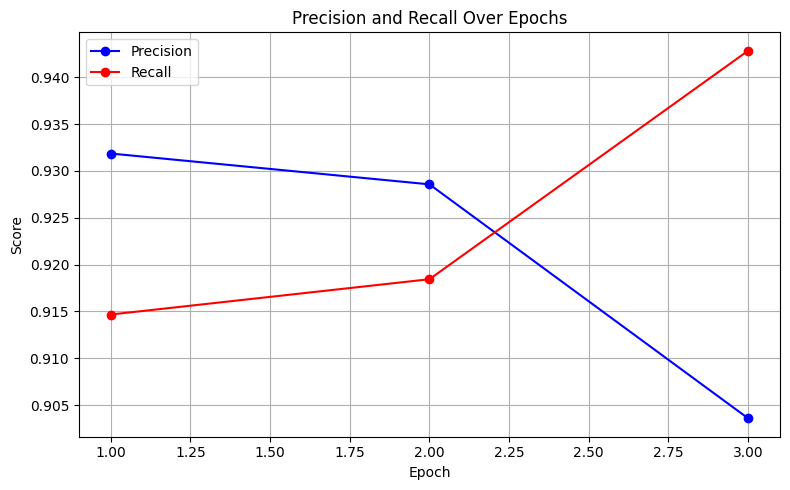

Final Evaluation: 100%|██████████| 625/625 [01:22<00:00,  7.58it/s]


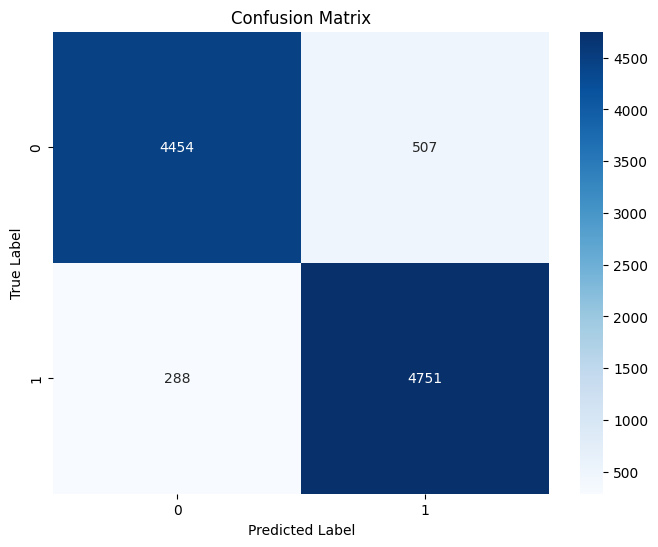


Final Evaluation Metrics:
Accuracy: 0.9205
Precision: 0.9036
Recall: 0.9428
F1 Score: 0.9228


In [ ]:
def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load and preprocess data
    df['sentiment'] = (df['sentiment'] == 'positive').astype(int)

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df['review'].values,
        df['sentiment'].values,
        test_size=0.2,
        random_state=42
    )

    # Load tokenizer and model locally
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', local_files_only=True)
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        local_files_only=True
    ).to(device)

    # Create datasets and dataloaders
    train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
    val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    # Train model and get training statistics
    training_stats = train_model(model, train_loader, val_loader, device)

    # Plot training metrics
    plot_training_metrics(training_stats) # calling Plot_training Metrix function

    # Final evaluation
    model.eval()
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Final Evaluation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            val_preds.extend(preds.cpu().numpy())
            val_true.extend(labels.cpu().numpy())

    # Plot confusion matrix
    plot_confusion_matrix(val_true, val_preds) # calling Plot confusion Matrix

    # Print final metrics
    accuracy = accuracy_score(val_true, val_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(val_true, val_preds, average='binary')

    print("\nFinal Evaluation Metrics:")
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

if __name__ == "__main__":
    main()

# Evalution Metrics

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    average_precision_score, classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class ModelEvaluator:
    def __init__(self, model_path='best_model.pt', tokenizer_path='bert-base-uncased'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load tokenizer and model
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path, local_files_only=True)
        self.model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels=2,
            local_files_only=True
        ).to(self.device)

        # Load fine-tuned model weights
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()

    def get_predictions(self, dataloader):
        """Get model predictions and true labels for entire dataset"""
        all_predictions = []
        all_probabilities = []
        all_labels = []

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
                predictions = torch.argmax(probabilities, dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Probability of positive class
                all_labels.extend(labels.cpu().numpy())

        return np.array(all_predictions), np.array(all_probabilities), np.array(all_labels)

    def plot_roc_curve(self, y_true, y_prob):
        """Plot ROC curve"""
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

        return roc_auc

    def plot_precision_recall_curve(self, y_true, y_prob):
        """Plot Precision-Recall curve"""
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        avg_precision = average_precision_score(y_true, y_prob)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2,
                label=f'Precision-Recall curve (AP = {avg_precision:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.show()

        return avg_precision

    def plot_confusion_matrix(self, y_true, y_pred):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        return cm

    def plot_probability_distribution(self, y_prob, y_true):
        """Plot probability distribution for each class"""
        plt.figure(figsize=(10, 6))

        # Separate probabilities for positive and negative classes
        pos_probs = y_prob[y_true == 1]
        neg_probs = y_prob[y_true == 0]

        plt.hist(neg_probs, bins=50, alpha=0.5, label='Negative Class', color='red')
        plt.hist(pos_probs, bins=50, alpha=0.5, label='Positive Class', color='green')

        plt.xlabel('Predicted Probability of Positive Class')
        plt.ylabel('Count')
        plt.title('Distribution of Predicted Probabilities')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate_model(self, dataloader):
        """Comprehensive model evaluation"""
        # Get predictions
        y_pred, y_prob, y_true = self.get_predictions(dataloader)

        print("=" * 50)
        print("MODEL EVALUATION METRICS")
        print("=" * 50)

        # 1. Classification Report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

        # 2. ROC Curve and AUC
        print("\nPlotting ROC Curve...")
        roc_auc = self.plot_roc_curve(y_true, y_prob)

        # 3. Precision-Recall Curve
        print("\nPlotting Precision-Recall Curve...")
        avg_precision = self.plot_precision_recall_curve(y_true, y_prob)

        # 4. Confusion Matrix
        print("\nPlotting Confusion Matrix...")
        cm = self.plot_confusion_matrix(y_true, y_pred)

        # 5. Probability Distribution
        print("\nPlotting Probability Distribution...")
        self.plot_probability_distribution(y_prob, y_true)

        # 6. Additional Metrics
        tn, fp, fn, tp = cm.ravel()

        # Calculate additional metrics
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        print("\nDetailed Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall (Sensitivity): {recall:.4f}")
        print(f"Specificity: {specificity:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Average Precision: {avg_precision:.4f}")

        # Return metrics dictionary
        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'specificity': specificity,
            'f1': f1,
            'roc_auc': roc_auc,
            'avg_precision': avg_precision,
            'confusion_matrix': cm
        }

def main():
    # Create test dataloader (you should use your validation/test set here)
    test_dataset = IMDBDataset(val_texts, val_labels, tokenizer)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # Initialize evaluator
    evaluator = ModelEvaluator()

    # Run evaluation
    metrics = evaluator.evaluate_model(test_loader)

    # You can access individual metrics like this:
    print(f"\nModel F1 Score: {metrics['f1']:.4f}")
    print(f"Model ROC AUC: {metrics['roc_auc']:.4f}")

if __name__ == "__main__":
    main()

NameError: name 'val_texts' is not defined

# Predictiveness testing

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np

class SentimentPredictor:
    def __init__(self, model_path='best_model.pt', tokenizer_path='bert-base-uncased'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load tokenizer and model
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path, local_files_only=True)
        self.model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels=2,
            local_files_only=True
        ).to(self.device)

        # Load the fine-tuned model weights
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()

    def preprocess_text(self, text, max_length=256):
        """Preprocess the input text."""
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].to(self.device),
            'attention_mask': encoding['attention_mask'].to(self.device)
        }

    def predict(self, text):
        """
        Predict sentiment for a given text.
        Returns: dict containing prediction, probability, and processed result
        """
        # Preprocess the text
        inputs = self.preprocess_text(text)

        # Get prediction
        with torch.no_grad():
            outputs = self.model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
            prediction = torch.argmax(probabilities, dim=1)
            confidence = probabilities[0][prediction[0]].item()

        # Process results
        sentiment = "positive" if prediction.item() == 1 else "negative"

        return {
            'text': text,
            'sentiment': sentiment,
            'confidence': f"{confidence*100:.2f}%",
            'prediction': prediction.item(),
            'raw_probabilities': {
                'negative': f"{probabilities[0][0].item()*100:.2f}%",
                'positive': f"{probabilities[0][1].item()*100:.2f}%"
            }
        }

    def predict_batch(self, texts):
        """
        Predict sentiment for a batch of texts.
        Returns: list of prediction dictionaries
        """
        return [self.predict(text) for text in texts]

# Example usage
def main():
    # Initialize predictor
    predictor = SentimentPredictor()

    # Example reviews
    example_reviews = [
        "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.",
        "I was really disappointed with this film. The story was confusing and the characters were poorly developed.",
        "While it had some good moments, overall the movie was just average.",
        "One of the best films I've seen this year! Everything about it was perfect!",
        "I couldn't even finish watching it. Complete waste of time."
    ]

    # Make predictions
    print("Making predictions for example reviews:\n")
    for result in predictor.predict_batch(example_reviews):
        print(f"\nReview: {result['text']}")
        print(f"Sentiment: {result['sentiment']}")
        print(f"Confidence: {result['confidence']}")
        print("Probability Distribution:")
        print(f"  Positive: {result['raw_probabilities']['positive']}")
        print(f"  Negative: {result['raw_probabilities']['negative']}")
        print("-" * 80)

# Function to predict single review
def predict_single_review(review_text, model_path='best_model.pt'):
    predictor = SentimentPredictor(model_path)
    result = predictor.predict(review_text)

    print(f"\nInput Review: {result['text']}")
    print(f"Predicted Sentiment: {result['sentiment'].upper()}")
    print(f"Confidence: {result['confidence']}")
    print("\nProbability Distribution:")
    print(f"Positive: {result['raw_probabilities']['positive']}")
    print(f"Negative: {result['raw_probabilities']['negative']}")

    return result

if __name__ == "__main__":
    main()

<ipython-input-13-b9861f4f4aa8>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=self.device))


Making predictions for example reviews:


Review: This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.
Sentiment: positive
Confidence: 99.60%
Probability Distribution:
  Positive: 99.60%
  Negative: 0.40%
--------------------------------------------------------------------------------

Review: I was really disappointed with this film. The story was confusing and the characters were poorly developed.
Sentiment: negative
Confidence: 99.45%
Probability Distribution:
  Positive: 0.55%
  Negative: 99.45%
--------------------------------------------------------------------------------

Review: While it had some good moments, overall the movie was just average.
Sentiment: negative
Confidence: 78.37%
Probability Distribution:
  Positive: 21.63%
  Negative: 78.37%
--------------------------------------------------------------------------------

Review: One of the best films I've seen this year! Everything about it was perfect!
Sentiment: positive
C

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np

class SentimentPredictor:
    def __init__(self, model_path='best_model.pt', tokenizer_path='bert-base-uncased'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load tokenizer and model
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path, local_files_only=True)
        self.model = BertForSequenceClassification.from_pretrained(
            'bert-base-uncased',
            num_labels=2,
            local_files_only=True
        ).to(self.device)

        # Load the fine-tuned model weights
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()

    def preprocess_text(self, text, max_length=256):
        """Preprocess the input text."""
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].to(self.device),
            'attention_mask': encoding['attention_mask'].to(self.device)
        }

    def predict(self, text):
        """
        Predict sentiment for a given text.
        Returns: dict containing prediction, probability, and processed result
        """
        # Preprocess the text
        inputs = self.preprocess_text(text)

        # Get prediction
        with torch.no_grad():
            outputs = self.model(**inputs)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
            prediction = torch.argmax(probabilities, dim=1)
            confidence = probabilities[0][prediction[0]].item()

        # Process results
        sentiment = "positive" if prediction.item() == 1 else "negative"

        return {
            'text': text,
            'sentiment': sentiment,
            'confidence': f"{confidence*100:.2f}%",
            'prediction': prediction.item(),
            'raw_probabilities': {
                'negative': f"{probabilities[0][0].item()*100:.2f}%",
                'positive': f"{probabilities[0][1].item()*100:.2f}%"
            }
        }

    def predict_batch(self, texts):
        """
        Predict sentiment for a batch of texts.
        Returns: list of prediction dictionaries
        """
        return [self.predict(text) for text in texts]

# Example usage
def main():
    # Initialize predictor
    predictor = SentimentPredictor()

    # Example reviews
    example_reviews = [
        "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.",
        "Thank you for the kind words, Md. I am sorry that the assistantship did not work out, but I hope you take Dr. Nasir and my feedback constructively. We both want the best for you. You did well on the final project, and I hope to see you succeed in the future. You can feel free to keep in touch and let me know if you have any questions on your career decisions",
        "While it had some good moments, overall the movie was just average.",
        "One of the best films I've seen this year! Everything about it was perfect!",
        "I couldn't even finish watching it. Complete waste of time."
    ]

    # Make predictions
    print("Making predictions for example reviews:\n")
    for result in predictor.predict_batch(example_reviews):
        print(f"\nReview: {result['text']}")
        print(f"Sentiment: {result['sentiment']}")
        print(f"Confidence: {result['confidence']}")
        print("Probability Distribution:")
        print(f"  Positive: {result['raw_probabilities']['positive']}")
        print(f"  Negative: {result['raw_probabilities']['negative']}")
        print("-" * 80)

# Function to predict single review
def predict_single_review(review_text, model_path='best_model.pt'):
    predictor = SentimentPredictor(model_path)
    result = predictor.predict(review_text)

    print(f"\nInput Review: {result['text']}")
    print(f"Predicted Sentiment: {result['sentiment'].upper()}")
    print(f"Confidence: {result['confidence']}")
    print("\nProbability Distribution:")
    print(f"Positive: {result['raw_probabilities']['positive']}")
    print(f"Negative: {result['raw_probabilities']['negative']}")

    return result

if __name__ == "__main__":
    main()

<ipython-input-15-8d671bf3098a>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path, map_location=self.device))


Making predictions for example reviews:


Review: This movie was absolutely fantastic! The acting was superb and the plot kept me engaged throughout.
Sentiment: positive
Confidence: 99.60%
Probability Distribution:
  Positive: 99.60%
  Negative: 0.40%
--------------------------------------------------------------------------------

Review: Thank you for the kind words, Md. I am sorry that the assistantship did not work out, but I hope you take Dr. Nasir and my feedback constructively. We both want the best for you. You did well on the final project, and I hope to see you succeed in the future. You can feel free to keep in touch and let me know if you have any questions on your career decisions
Sentiment: positive
Confidence: 95.00%
Probability Distribution:
  Positive: 95.00%
  Negative: 5.00%
--------------------------------------------------------------------------------

Review: While it had some good moments, overall the movie was just average.
Sentiment: negative
Confidence: 78.37